##### Copyright 2024 The AI Edge Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Inspecting Quantization Errors with Quantization Debugger

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/performance/quantization_debugger"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/performance/quantization_debugger.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/performance/quantization_debugger.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/performance/quantization_debugger.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

Although full-integer quantization provides improved model size and latency, the
quantized model won't always work as expected. It's usually expected for the
model quality (e.g. accuracy, mAP, WER) to be slightly lower than the original
float model. However, there are cases where the model quality can go below your
expectation or generated completely wrong results.

When this problem happens, it's tricky and painful to spot the root cause of the
quantization error, and it's even more difficult to fix the quantization error.
To assist this model inspection process, **quantization debugger** can be used
to identify problematic layers, and **selective quantization** can leave those
problematic layers in float so that the model accuracy can be recovered at the
cost of reduced benefit from quantization.

Note: This API is experimental, and there might be breaking changes in the API
in the course of improvements.

## Quantization Debugger

Quantization debugger makes it possible to do quantization quality metric
analysis in the existing model. Quantization debugger can automate processes for
running model with a debug dataset, and collecting quantization quality metrics
for each tensors.

Note: Quantization debugger and selective quantization currently only works for
full-integer quantization with int8 activations.

### Prerequisites

If you already have a pipeline to quantize a model, you have all necessary
pieces to run quantization debugger!

*   Model to quantize
*   Representative dataset

In addition to model and data, you will need to use a data processing framework
(e.g. pandas, Google Sheets) to analyze the exported results.

### Setup

This section prepares libraries, MobileNet v3 model, and test dataset of 100
images.

In [15]:
!pip uninstall -y tensorflow tf-nightly tensorflow-datasets tensorflow_hub keras tf_keras
!pip install tensorflow==2.10.0 tensorflow-hub==0.13.0 tensorflow-datasets keras

Found existing installation: tensorflow 2.10.0
Uninstalling tensorflow-2.10.0:
  Successfully uninstalled tensorflow-2.10.0
Found existing installation: tensorflow-datasets 4.9.0
Uninstalling tensorflow-datasets-4.9.0:
  Successfully uninstalled tensorflow-datasets-4.9.0
Found existing installation: tensorflow-hub 0.13.0
Uninstalling tensorflow-hub-0.13.0:
  Successfully uninstalled tensorflow-hub-0.13.0
Found existing installation: keras 2.10.0
Uninstalling keras-2.10.0:
  Successfully uninstalled keras-2.10.0
  Using cached tensorflow-2.10.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.1 kB)
  Using cached tensorflow_hub-0.13.0-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached tensorflow_datasets-4.9.7-py3-none-any.whl.metadata (9.6 kB)
  Using cached keras-3.7.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached keras-2.10.0-py2.py3-none-any.whl.metadata (1.3 kB)
INFO: pip is looking at multiple versions of tensorflow-datasets to determine which version 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub


In [2]:
# #@title Boilerplates and helpers
MODEL_URI = 'https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5'


def process_image(data):
  data['image'] = tf.image.resize(data['image'], (224, 224)) / 255.0
  return data


# Representative dataset
def representative_dataset(dataset):

  def _data_gen():
    for data in dataset.batch(1):
      yield [data['image']]

  return _data_gen


def eval_tflite(tflite_model, dataset):
  """Evaluates LiteRT classification model with the given dataset."""
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_idx = interpreter.get_input_details()[0]['index']
  output_idx = interpreter.get_output_details()[0]['index']

  results = []

  for data in representative_dataset(dataset)():
    interpreter.set_tensor(input_idx, data[0])
    interpreter.invoke()
    results.append(interpreter.get_tensor(output_idx).flatten())

  results = np.array(results)
  gt_labels = np.array(list(dataset.map(lambda data: data['label'] + 1)))
  accuracy = (
      np.sum(np.argsort(results, axis=1)[:, -5:] == gt_labels.reshape(-1, 1)) /
      gt_labels.size)
  print(f'Top-5 accuracy (quantized): {accuracy * 100:.2f}%')


model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(224, 224, 3), batch_size=1),
  hub.KerasLayer(MODEL_URI)
])
model.compile(
    loss='sparse_categorical_crossentropy',
    metrics='sparse_top_k_categorical_accuracy')
model.build([1, 224, 224, 3])

# Prepare dataset with 100 examples
ds = tfds.load('imagenet_v2', split='test[:1%]')
ds = ds.map(process_image)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.representative_dataset = representative_dataset(ds)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_model = converter.convert()


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [1]:
# #@title Boilerplates and helpers
# MODEL_URI = 'https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5'


# def process_image(data):
#   data['image'] = tf.image.resize(data['image'], (224, 224)) / 255.0
#   return data


# # Representative dataset
# def representative_dataset(dataset):

#   def _data_gen():
#     for data in dataset.batch(1):
#       yield [data['image']]

#   return _data_gen


# def eval_tflite(tflite_model, dataset):
#   """Evaluates tensorflow lite classification model with the given dataset."""
#   interpreter = tf.lite.Interpreter(model_content=tflite_model)
#   interpreter.allocate_tensors()

#   input_idx = interpreter.get_input_details()[0]['index']
#   output_idx = interpreter.get_output_details()[0]['index']

#   results = []

#   for data in representative_dataset(dataset)():
#     interpreter.set_tensor(input_idx, data[0])
#     interpreter.invoke()
#     results.append(interpreter.get_tensor(output_idx).flatten())

#   results = np.array(results)
#   gt_labels = np.array(list(dataset.map(lambda data: data['label'] + 1)))
#   accuracy = (
#       np.sum(np.argsort(results, axis=1)[:, -5:] == gt_labels.reshape(-1, 1)) /
#       gt_labels.size)
#   print(f'Top-5 accuracy (quantized): {accuracy * 100:.2f}%')

# # Instead of adding KerasLayer after InputLayer, directly load the model from the URI
#   #model = tf.keras.models.load_model(MODEL_URI)

# model = tf.keras.Sequential()  # Create an empty Sequential model
# # model.add(tf.keras.layers.InputLayer(shape=(224, 224, 3), batch_size=1))  # Add input layer
# # model.add(hub.KerasLayer(MODEL_URI)) # Add the KerasLayer

# model = tf.keras.Sequential([
#   tf.keras.layers.Input(shape=(224, 224, 3), batch_size=1),
#   hub.KerasLayer(MODEL_URI)
# ])
# model.compile(
#     loss='sparse_categorical_crossentropy',
#     metrics=['sparse_top_k_categorical_accuracy'])
# model.build([1, 224, 224, 3])

# # Prepare dataset with 100 examples
# ds = tfds.load('imagenet_v2', split='test[:1%]')
# ds = ds.map(process_image)

# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.representative_dataset = representative_dataset(ds)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# quantized_model = converter.convert()

In [3]:
test_ds = ds.map(lambda data: (data['image'], data['label'] + 1)).batch(16)
loss, acc = model.evaluate(test_ds)
print(f'Top-5 accuracy (float): {acc * 100:.2f}%')

7/7 [==============================] - 3s 272ms/step - loss: 88.6092 - sparse_top_k_categorical_accuracy: 11.7143
Top-5 accuracy (float): 1171.43%


In [4]:
eval_tflite(quantized_model, ds)

Top-5 accuracy (quantized): 54.00%


We can see that the original model has a much higher top-5 accuracy for our
small dataset, while the quantized model has a significant accuracy loss.

### Step 1. Debugger preparation

Easiest way to use the quantization debugger is to provide
`tf.lite.TFLiteConverter` that you have been using to quantize the model.

In [5]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset(ds)

# my_debug_dataset should have the same format as my_representative_dataset
debugger = tf.lite.experimental.QuantizationDebugger(
    converter=converter, debug_dataset=representative_dataset(ds))

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


### Step 2. Running the debugger and getting the results

When you call `QuantizationDebugger.run()`, the debugger will log differences
between float tensors and quantized tensors for the same op location, and
process them with given metrics.

In [6]:
debugger.run()

The processed metrics can be accessed with
`QuantizationDebugger.layer_statistics`, or can be dumped to a text file in CSV
format with `QuantizationDebugger.layer_statistics_dump()`.

In [7]:
RESULTS_FILE = '/tmp/debugger_results.csv'
with open(RESULTS_FILE, 'w') as f:
  debugger.layer_statistics_dump(f)

In [8]:
!head /tmp/debugger_results.csv

op_name,tensor_idx,num_elements,stddev,mean_error,max_abs_error,mean_squared_error,scale,zero_point,tensor_name
MUL,227,150528.0,0.0021623536,-2.0737803e-06,0.0039216112,4.713237e-06,0.007843138,-128,predict/hub_input/Mul;predict/hub_input/Mul
SUB,231,150528.0,0.0034957642,-0.00051877555,0.0039216876,1.5378853e-05,0.007843138,-1,predict/hub_input/Sub;predict/hub_input/Sub
CONV_2D,235,200704.0,0.04148241,0.00025516152,0.10226499,0.0017259402,0.14247456,-30,predict/MobilenetV3/Conv/BatchNorm/FusedBatchNormV3;predict/MobilenetV3/Conv/BatchNorm/FusedBatchNormV3;predict/MobilenetV3/expanded_conv/project/Conv2D;predict/MobilenetV3/expanded_conv/project/Conv2D;predict/MobilenetV3/Conv/Conv2D;predict/MobilenetV3/Conv/Conv2D
HARD_SWISH,239,200704.0,0.029794993,-0.00047417585,0.04524803,0.0008921472,0.08929687,-124,predict/MobilenetV3/Conv/hard_swish/mul_1;predict/MobilenetV3/Conv/hard_swish/mul_1;predict/MobilenetV3/Conv/hard_swish/add/y;predict/MobilenetV3/Conv/hard_swish/add/y;predict/Mobilen

For each row in the dump, the op name and index comes first, followed by
quantization parameters and error metrics (including
[user-defined error metrics](#custom-metrics), if any). The resulting CSV file
can be used to pick problematic layers with large quantization error metrics.

With pandas or other data processing libraries, we can inspect detailed
per-layer error metrics.

In [9]:
layer_stats = pd.read_csv(RESULTS_FILE)
layer_stats.head()

,op_name,tensor_idx,num_elements,stddev,mean_error,max_abs_error,mean_squared_error,scale,zero_point,tensor_name
0,MUL,227,150528.0,0.002162,-0.000002,0.003922,0.000005,0.007843,-128,predict/hub_input/Mul;predict/hub_input/Mul
1,SUB,231,150528.0,0.003496,-0.000519,0.003922,0.000015,0.007843,-1,predict/hub_input/Sub;predict/hub_input/Sub
2,CONV_2D,235,200704.0,0.041482,0.000255,0.102265,0.001726,0.142475,-30,predict/MobilenetV3/Conv/BatchNorm/FusedBatchN...
3,HARD_SWISH,239,200704.0,0.029795,-0.000474,0.045248,0.000892,0.089297,-124,predict/MobilenetV3/Conv/hard_swish/mul_1;pred...
4,DEPTHWISE_CONV_2D,243,50176.0,0.213531,-0.016955,0.717270,0.045962,0.508746,-128,predict/MobilenetV3/expanded_conv/depthwise/Re...


### Step 3. Data analysis

There are various ways to analyze the resulting. First, let's add some useful
metrics derived from the debugger's outputs. (`scale` means the quantization
scale factor for each tensor.)

*   Range (`256 / scale`)
*   RMSE / scale (`sqrt(mean_squared_error) / scale`)

The `RMSE / scale` is close to `1 / sqrt(12)` (~ 0.289) when quantized
distribution is similar to the original float distribution, indicating a good
quantized model. The larger the value is, it's more likely for the layer not
being quantized well.

In [10]:
layer_stats['range'] = 255.0 * layer_stats['scale']
layer_stats['rmse/scale'] = layer_stats.apply(
    lambda row: np.sqrt(row['mean_squared_error']) / row['scale'], axis=1)
layer_stats[['op_name', 'range', 'rmse/scale']].head()

,op_name,range,rmse/scale
0,MUL,2.000000,0.276802
1,SUB,2.000000,0.500002
2,CONV_2D,36.331013,0.291592
3,HARD_SWISH,22.770702,0.334489
4,DEPTHWISE_CONV_2D,129.730204,0.421406


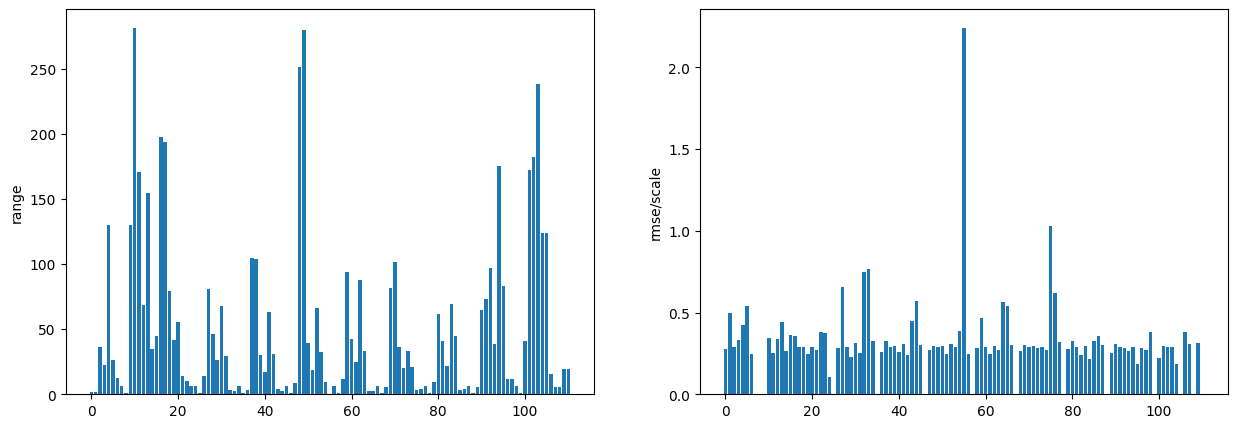

In [11]:
plt.figure(figsize=(15, 5))
ax1 = plt.subplot(121)
ax1.bar(np.arange(len(layer_stats)), layer_stats['range'])
ax1.set_ylabel('range')
ax2 = plt.subplot(122)
ax2.bar(np.arange(len(layer_stats)), layer_stats['rmse/scale'])
ax2.set_ylabel('rmse/scale')
plt.show()

There are many layers with wide ranges, and some layers that have high
`RMSE/scale` values. Let's get the layers with high error metrics.

In [12]:
layer_stats[layer_stats['rmse/scale'] > 0.7][[
    'op_name', 'range', 'rmse/scale', 'tensor_name'
]]

,op_name,range,rmse/scale,tensor_name
32,MEAN,3.300810,0.748280,predict/MobilenetV3/expanded_conv_4/squeeze_ex...
33,CONV_2D,2.866467,0.764711,predict/MobilenetV3/expanded_conv_4/squeeze_ex...
55,CONV_2D,0.001957,2.242781,predict/MobilenetV3/expanded_conv_6/squeeze_ex...
75,MEAN,3.214616,1.028382,predict/MobilenetV3/expanded_conv_8/squeeze_ex...


With these layers, you can try selective quantization to see if not quantizing
those layers improves model quality.

In [13]:
suspected_layers = list(
    layer_stats[layer_stats['rmse/scale'] > 0.7]['tensor_name'])

In addition to these, skipping quantization for the first few layers also helps
improving quantized model's quality.

In [14]:
suspected_layers.extend(list(layer_stats[:5]['tensor_name']))

## Selective Quantization

Selective quantization skips quantization for some nodes, so that the
calculation can happen in the original floating-point domain. When correct
layers are skipped, we can expect some model quality recovery at the cost of
increased latency and model size.

However, if you're planning to run quantized models on integer-only accelerators
(e.g. Hexagon DSP, EdgeTPU), selective quantization would cause fragmentation of
the model and would result in slower inference latency mainly caused by data
transfer cost between CPU and those accelerators. To prevent this, you can
consider running
[quantization aware training](https://www.tensorflow.org/model_optimization/guide/quantization/training)
to keep all the layers in integer while preserving the model accuracy.

Quantization debugger's option accepts `denylisted_nodes` and `denylisted_ops`
options for skipping quantization for specific layers, or all instances of
specific ops. Using `suspected_layers` we prepared from the previous step, we
can use quantization debugger to get a selectively quantized model.

In [ ]:
debug_options = tf.lite.experimental.QuantizationDebugOptions(
    denylisted_nodes=suspected_layers)
debugger = tf.lite.experimental.QuantizationDebugger(
    converter=converter,
    debug_dataset=representative_dataset(ds),
    debug_options=debug_options)

In [ ]:
selective_quantized_model = debugger.get_nondebug_quantized_model()
eval_tflite(selective_quantized_model, ds)

The accuracy is still lower compared to the original float model, but we have
notable improvement from the whole quantized model by skipping quantization for
~10 layers out of 111 layers.

You can also try to not quantized all ops in the same class. For example, to
skip quantization for all mean ops, you can pass `MEAN` to `denylisted_ops`.

In [ ]:
debug_options = tf.lite.experimental.QuantizationDebugOptions(
    denylisted_ops=['MEAN'])
debugger = tf.lite.experimental.QuantizationDebugger(
    converter=converter,
    debug_dataset=representative_dataset(ds),
    debug_options=debug_options)

In [ ]:
selective_quantized_model = debugger.get_nondebug_quantized_model()
eval_tflite(selective_quantized_model, ds)

With these techniques, we are able to improve the quantized MobileNet V3 model
accuracy. Next we'll explore advanced techniques to improve the model accuracy
even more.

## Advanced usages

Whith following features, you can further customize your debugging pipeline.

### Custom metrics

By default, the quantization debugger emits five metrics for each float-quant
difference: tensor size, standard deviation, mean error, max absolute error, and
mean squared error. You can add more custom metrics by passing them to options.
For each metrics, the result should be a single float value and the resulting
metric will be an average of metrics from all examples.

*   `layer_debug_metrics`: calculate metric based on diff for each op outputs
    from float and quantized op outputs.
*   `layer_direct_compare_metrics`: rather than getting diff only, this will
    calculate metric based on raw float and quantized tensors, and its
    quantization parameters (scale, zero point)
*   `model_debug_metrics`: **only used when `float_model_(path|content)` is
    passed** to the debugger. In addition to the op-level metrics, final layer
    output is compared to the reference output from the original float model.

In [ ]:
debug_options = tf.lite.experimental.QuantizationDebugOptions(
    layer_debug_metrics={
        'mean_abs_error': (lambda diff: np.mean(np.abs(diff)))
    },
    layer_direct_compare_metrics={
        'correlation':
            lambda f, q, s, zp: (np.corrcoef(f.flatten(),
                                             (q.flatten() - zp) / s)[0, 1])
    },
    model_debug_metrics={
        'argmax_accuracy': (lambda f, q: np.mean(np.argmax(f) == np.argmax(q)))
    })

debugger = tf.lite.experimental.QuantizationDebugger(
    converter=converter,
    debug_dataset=representative_dataset(ds),
    debug_options=debug_options)

In [ ]:
debugger.run()

In [ ]:
CUSTOM_RESULTS_FILE = '/tmp/debugger_results.csv'
with open(CUSTOM_RESULTS_FILE, 'w') as f:
  debugger.layer_statistics_dump(f)

custom_layer_stats = pd.read_csv(CUSTOM_RESULTS_FILE)
custom_layer_stats[['op_name', 'mean_abs_error', 'correlation']].tail()

The result of `model_debug_metrics` can be separately seen from
`debugger.model_statistics`.

In [ ]:
debugger.model_statistics

### Using (internal) mlir_quantize API to access in-depth features

Note: Some features in the folowing section,
`TFLiteConverter._experimental_calibrate_only` and `converter.mlir_quantize` are
experimental internal APIs, and subject to change in a non-backward compatible
way.

In [ ]:
from tensorflow.lite.python import convert

#### Whole model verify mode

The default behavior for the debug model generation is per-layer verify. In this
mode, the input for float and quantize op pair is from the same source (previous
quantized op). Another mode is whole-model verify, where the float and quantize
models are separated. This mode would be useful to observe how the error is
being propagated down the model. To enable, `enable_whole_model_verify=True` to
`convert.mlir_quantize` while generating the debug model manually.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.representative_dataset = representative_dataset(ds)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter._experimental_calibrate_only = True
calibrated_model = converter.convert()

In [ ]:
# Note that enable_numeric_verify and enable_whole_model_verify are set.
quantized_model = convert.mlir_quantize(
    calibrated_model,
    enable_numeric_verify=True,
    enable_whole_model_verify=True)
debugger = tf.lite.experimental.QuantizationDebugger(
    quant_debug_model_content=quantized_model,
    debug_dataset=representative_dataset(ds))

#### Selective quantization from an already calibrated model

You can directly call `convert.mlir_quantize` to get the selective quantized
model from already calibrated model. This would be particularly useful when you
want to calibrate the model once, and experiment with various denylist
combinations.

In [ ]:
selective_quantized_model = convert.mlir_quantize(
    calibrated_model, denylisted_nodes=suspected_layers)
eval_tflite(selective_quantized_model, ds)